**DOMAIN**: Semiconductor manufacturing process

**CONTEXT**: A complex modern semiconductor manufacturing process is normally under constant surveillance via the monitoring of signals/variables collected from sensors and or process measurement points. However, not all of these signals are equally valuable in a specific monitoring system. The measured signals contain a combination of useful information, irrelevant information as well as noise.
Engineers typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then feature selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key factors contributing to yield excursions downstream in the process. This will enable an increase in process throughput, decreased time to learning and reduce the per unit production costs. These signals can be used as features to predict the yield type. And by analysing and trying out different combinations of features, essential signals that are impacting the yield type can be identified.

**DATA DESCRIPTION**: signal-data.csv : (1567, 592)
* The data consists of 1567 datapoints each with 591 features.
* The dataset presented in this case represents a selection of such features where each example represents a single production entity with associated measured features and the labels represent a simple pass/fail yield for in house line testing. Target column “ –1” corresponds to a pass and “1” corresponds to a fail and the data time stamp is for that specific test point.

**PROJECT OBJECTIVE**: We will build a classifier to predict the Pass/Fail yield of a particular process entity and analyse whether all the features are required to build the model or not.

# Steps and tasks:
## 1. Import and understand the data.
### A. Import ‘signal-data.csv’ as DataFrame.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset
df = pd.read_csv("signal-data.csv")

# Display the first few rows of the dataframe
print(df.head())

# Display info about the dataframe
df.info()

                  Time        0        1          2          3       4      5  \
0  2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
1  2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2  2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
3  2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
4  2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

          6       7       8  ...       581     582     583     584      585  \
0   97.6133  0.1242  1.5005  ...       NaN  0.5005  0.0118  0.0035   2.3630   
1  102.3433  0.1247  1.4966  ...  208.2045  0.5019  0.0223  0.0055   4.4447   
2   95.4878  0.1241  1.4436  ...   82.8602  0.4958  0.0157  0.0039   3.1745   
3  104.2367  0.1217  1.4882  ...   73.8432  0.4990  0.0103  0.0025   2.0544   
4  100.3967  0.1235  1.5031  ...       NaN  0.4800  0.4766  0.1045  99.3032   

      586     587     588       589  P

### B. Print 5 point summary and share at least 2 observations. 

In [3]:
# Display descriptive statistics for the dataframe
print(df.describe().T)

            count         mean         std        min          25%        50%  \
0          1561.0  3014.452896   73.621787  2743.2400  2966.260000  3011.4900   
1          1560.0  2495.850231   80.407705  2158.7500  2452.247500  2499.4050   
2          1553.0  2200.547318   29.513152  2060.6600  2181.044400  2201.0667   
3          1553.0  1396.376627  441.691640     0.0000  1081.875800  1285.2144   
4          1553.0     4.197013   56.355540     0.6815     1.017700     1.3168   
...           ...          ...         ...        ...          ...        ...   
586        1566.0     0.021458    0.012358    -0.0169     0.013425     0.0205   
587        1566.0     0.016475    0.008808     0.0032     0.010600     0.0148   
588        1566.0     0.005283    0.002867     0.0010     0.003300     0.0046   
589        1566.0    99.670066   93.891919     0.0000    44.368600    71.9005   
Pass/Fail  1567.0    -0.867262    0.498010    -1.0000    -1.000000    -1.0000   

                 75%       

**Observations**:

1. Feature Distribution and Variability:

* The features (columns 0 to 589) exhibit a wide range of means and standard deviations. For instance, feature 0 has a mean of approximately 3014.45 with a standard deviation of 73.62, while feature 4 has a much lower mean of 4.20 but a high standard deviation of 56.36. This indicates that the features vary significantly in their scale and spread.
* The maximum values of the features also show substantial differences. For example, feature 3 has a maximum value of 3715.04, while feature 588 has a maximum value of just 0.0286. Such variability suggests that normalization or standardization might be necessary before applying machine learning models.

2. Class Imbalance in Target Variable:

* The target variable, "Pass/Fail", is heavily imbalanced with a mean of -0.867 and a standard deviation of 0.498. The quartile statistics (25th, 50th, and 75th percentiles) all show a value of -1, indicating that the majority of the data points belong to the "pass" class (-1). Only a smaller fraction belongs to the "fail" class (1). This class imbalance needs to be addressed during model building, possibly through techniques like resampling, class weighting, or using specialized algorithms designed to handle imbalanced data.

## 2. Data cleansing:
### A. Write a for loop which will remove all the features with 20%+ Null values and impute rest with mean of the feature.

In [4]:
# Drop the 'Time' column as it is not needed for analysis
data = df.drop(columns=['Time'])

# Loop to remove features with 20%+ null values and impute the rest with mean
threshold = 0.2  # 20% threshold for null values
for col in data.columns:
    if data[col].isnull().mean() >= threshold:
        data.drop(col, axis=1, inplace=True)
    else:
        data[col].fillna(data[col].mean(), inplace=True)

# Display info after null value handling
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 559 entries, 0 to Pass/Fail
dtypes: float64(558), int64(1)
memory usage: 6.7 MB
None


### B. Identify and drop the features which are having same value for all the rows.

In [5]:
# Identify and drop constant value features
constant_features = data.columns[data.nunique() == 1]
data.drop(constant_features, axis=1, inplace=True)

# Display info after dropping constant features
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 443 entries, 0 to Pass/Fail
dtypes: float64(442), int64(1)
memory usage: 5.3 MB
None


### C. Drop other features if required using relevant functional knowledge. Clearly justify the same.

Already removed 'Time' as it is not necessary for analysis since it doesn't directly contribute to predicting the target variable (e.g., pass/fail yield)

### D - Check for multi-collinearity in the data and take necessary action.

In [7]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Find pairs of highly correlated features with correlation coefficient greater than 0.9
high_corr_pairs = np.where(np.abs(corr_matrix) > 0.9)
high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_pairs) if x != y and x < y]

# Remove one feature from each highly correlated pair
features_to_drop = set()
for pair in high_corr_pairs:
    features_to_drop.add(pair[1])

data_cleaned = data.drop(columns=features_to_drop)

# Print the shape of the data after cleaning
cleaned_data_shape = data_cleaned.shape
print(f"Shape after cleaning: {cleaned_data_shape}")

Shape after cleaning: (1567, 248)


### E - Make all relevant modifications on the data using both functional/logical reasoning/assumptions

In [8]:
# Ensure all columns except the target are numeric
data_cleaned = data_cleaned.apply(pd.to_numeric, errors='coerce')

# Scale the features
scaler = StandardScaler()
feature_columns = data_cleaned.columns.difference(['Pass/Fail'])
data_cleaned[feature_columns] = scaler.fit_transform(data_cleaned[feature_columns])

# Print the shape of the data after cleaning
cleaned_data_shape = data_cleaned.shape
print(f"Shape after scaling: {cleaned_data_shape}")

# Check for any remaining null values (should be none after imputation)
remaining_nulls = data_cleaned.isnull().sum().sum()
print(f"Remaining null values in the dataset: {remaining_nulls}")

Shape after scaling: (1567, 248)
Remaining null values in the dataset: 0


## 3. Data analysis & visualisation:
### A. Perform a detailed univariate Analysis with appropriate detailed comments after each analysis.

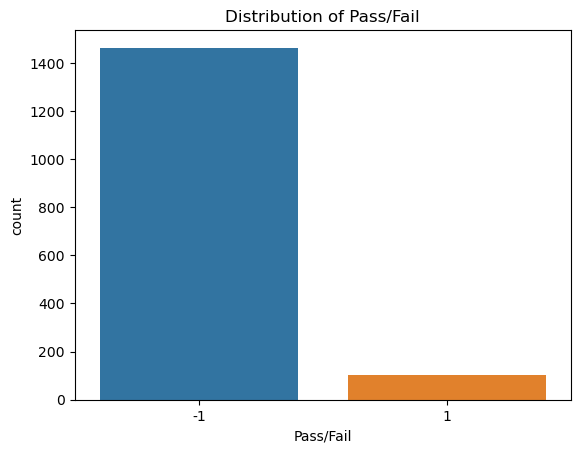

                  0             1             2             3             4  \
count  1.567000e+03  1.567000e+03  1.567000e+03  1.567000e+03  1.567000e+03   
mean   2.448584e-15 -3.814009e-15 -8.706076e-15 -2.720649e-16  1.813766e-17   
std    1.000319e+00  1.000319e+00  1.000319e+00  1.000319e+00  1.000319e+00   
min   -3.692123e+00 -4.203130e+00 -4.762680e+00 -3.176669e+00 -6.268170e-02   
25%   -6.505546e-01 -5.357114e-01 -6.621157e-01 -7.108971e-01 -5.668724e-02   
50%   -3.557033e-02  3.815069e-02  1.390060e-02 -2.480201e-01 -5.134893e-02   
75%    5.729476e-01  5.348329e-01  5.960931e-01  4.408676e-01 -4.756005e-02   
max    4.654374e+00  4.371324e+00  3.905799e+00  5.274818e+00  1.979739e+01   

                  6             7             8             9           10  \
count  1.567000e+03  1.567000e+03  1.567000e+03  1.567000e+03  1567.000000   
mean  -5.441297e-17  1.178948e-16  3.137815e-15  9.068829e-18     0.000000   
std    1.000319e+00  1.000319e+00  1.000319e+00  1.000

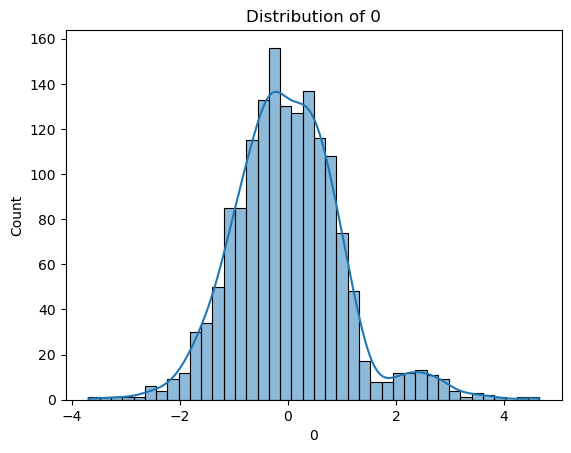

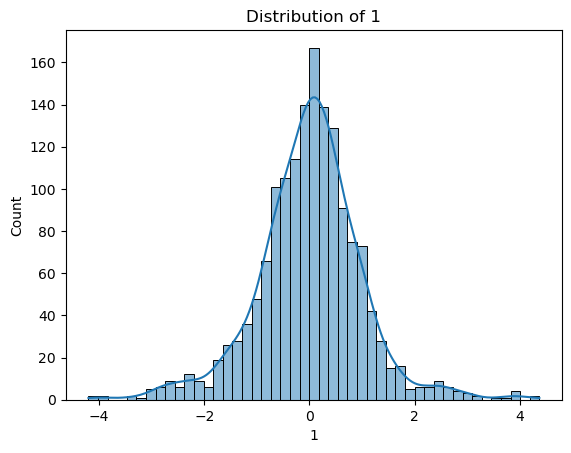

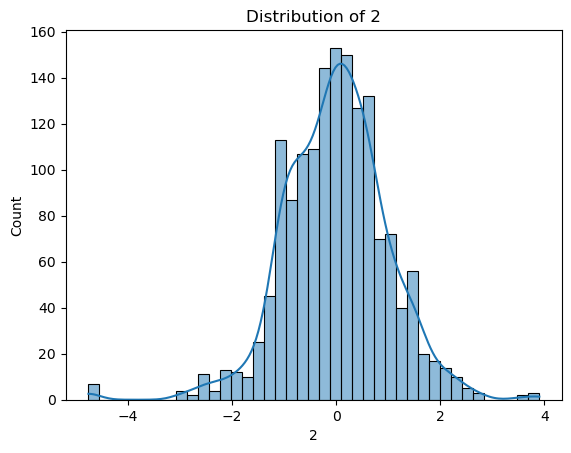

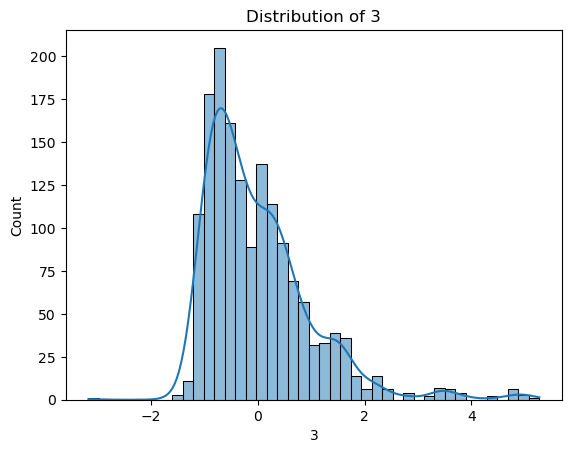

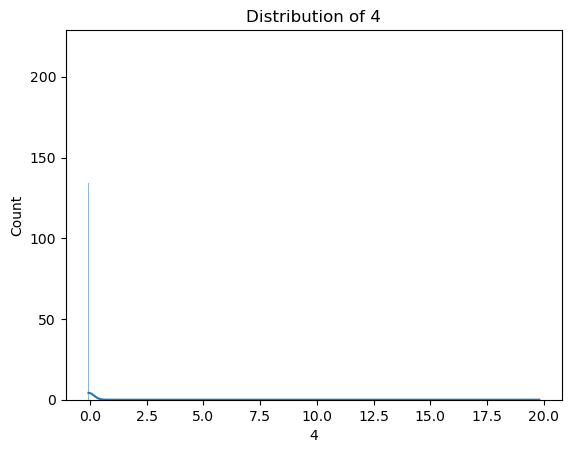

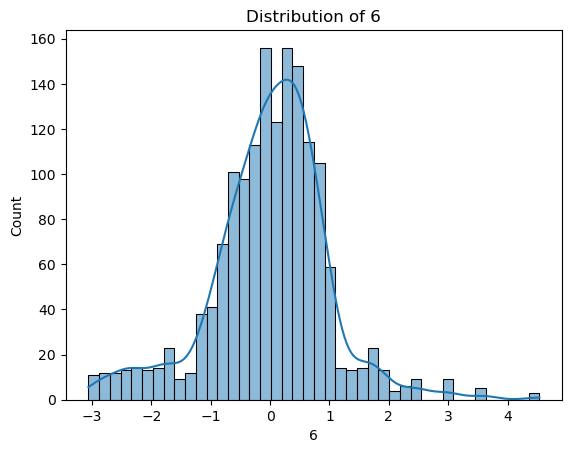

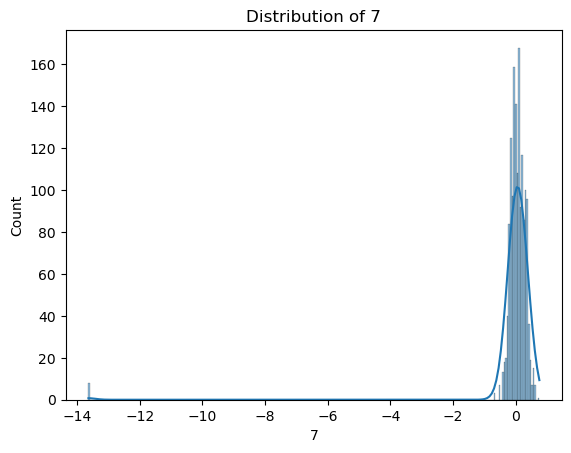

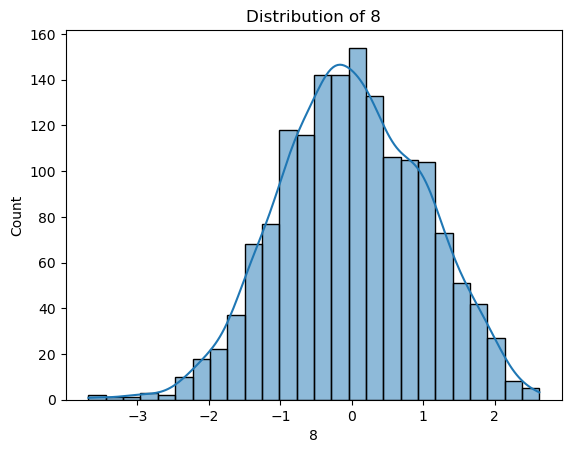

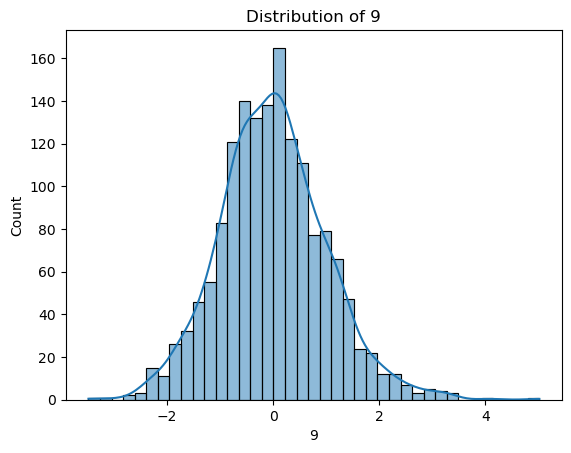

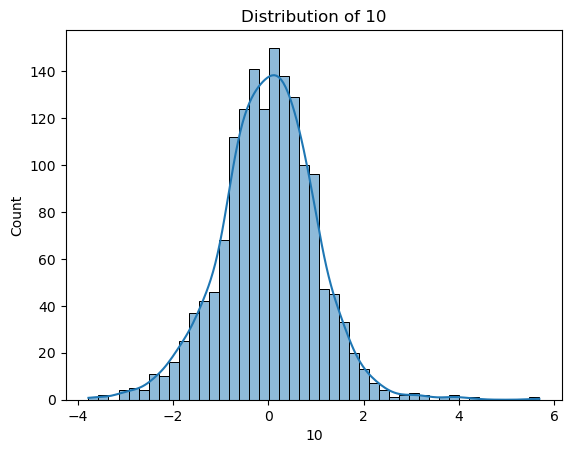

In [9]:
# Plot the distribution of the target variable
sns.countplot(x='Pass/Fail', data=data_cleaned)
plt.title('Distribution of Pass/Fail')
plt.show()

# Descriptive statistics for each feature
data_desc = data_cleaned.describe()
print(data_desc)

# Plot distributions for a few selected features
selected_features = data_cleaned.columns[:10]  # Just taking the first 10 features for demonstration

for feature in selected_features:
    sns.histplot(data_cleaned[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

* The 'Pass/Fail' target variable shows a skewed distribution towards -1 (fail). About 86.7% of the samples belong to the fail class (-1), and only about 13.3% belong to the pass class (1). This suggests an imbalanced classification problem.
* Since the classes are imbalanced, classifiers may be biased towards predicting the majority class (fail). Techniques like SMOTE, class weighting, or different evaluation metrics (like F1-score, ROC-AUC) should be considered to handle this imbalance.
* With 248 features, there might be issues related to curse of dimensionality, overfitting, and computational complexity. Feature selection or dimensionality reduction techniques (like PCA) could be beneficial.

### B. Perform bivariate and multivariate analysis with appropriate detailed comments after each analysis.

Pass/Fail    1.000000
59           0.155771
103          0.151196
510          0.131587
431          0.120304
               ...   
180         -0.078648
26          -0.081146
125         -0.083874
316         -0.089410
28          -0.106767
Name: Pass/Fail, Length: 248, dtype: float64


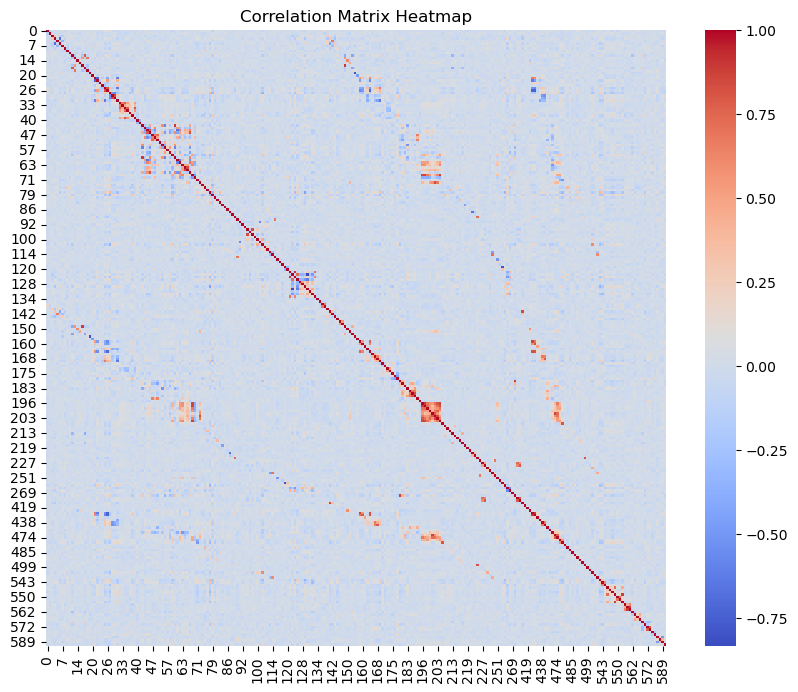

C:\Users\janne\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


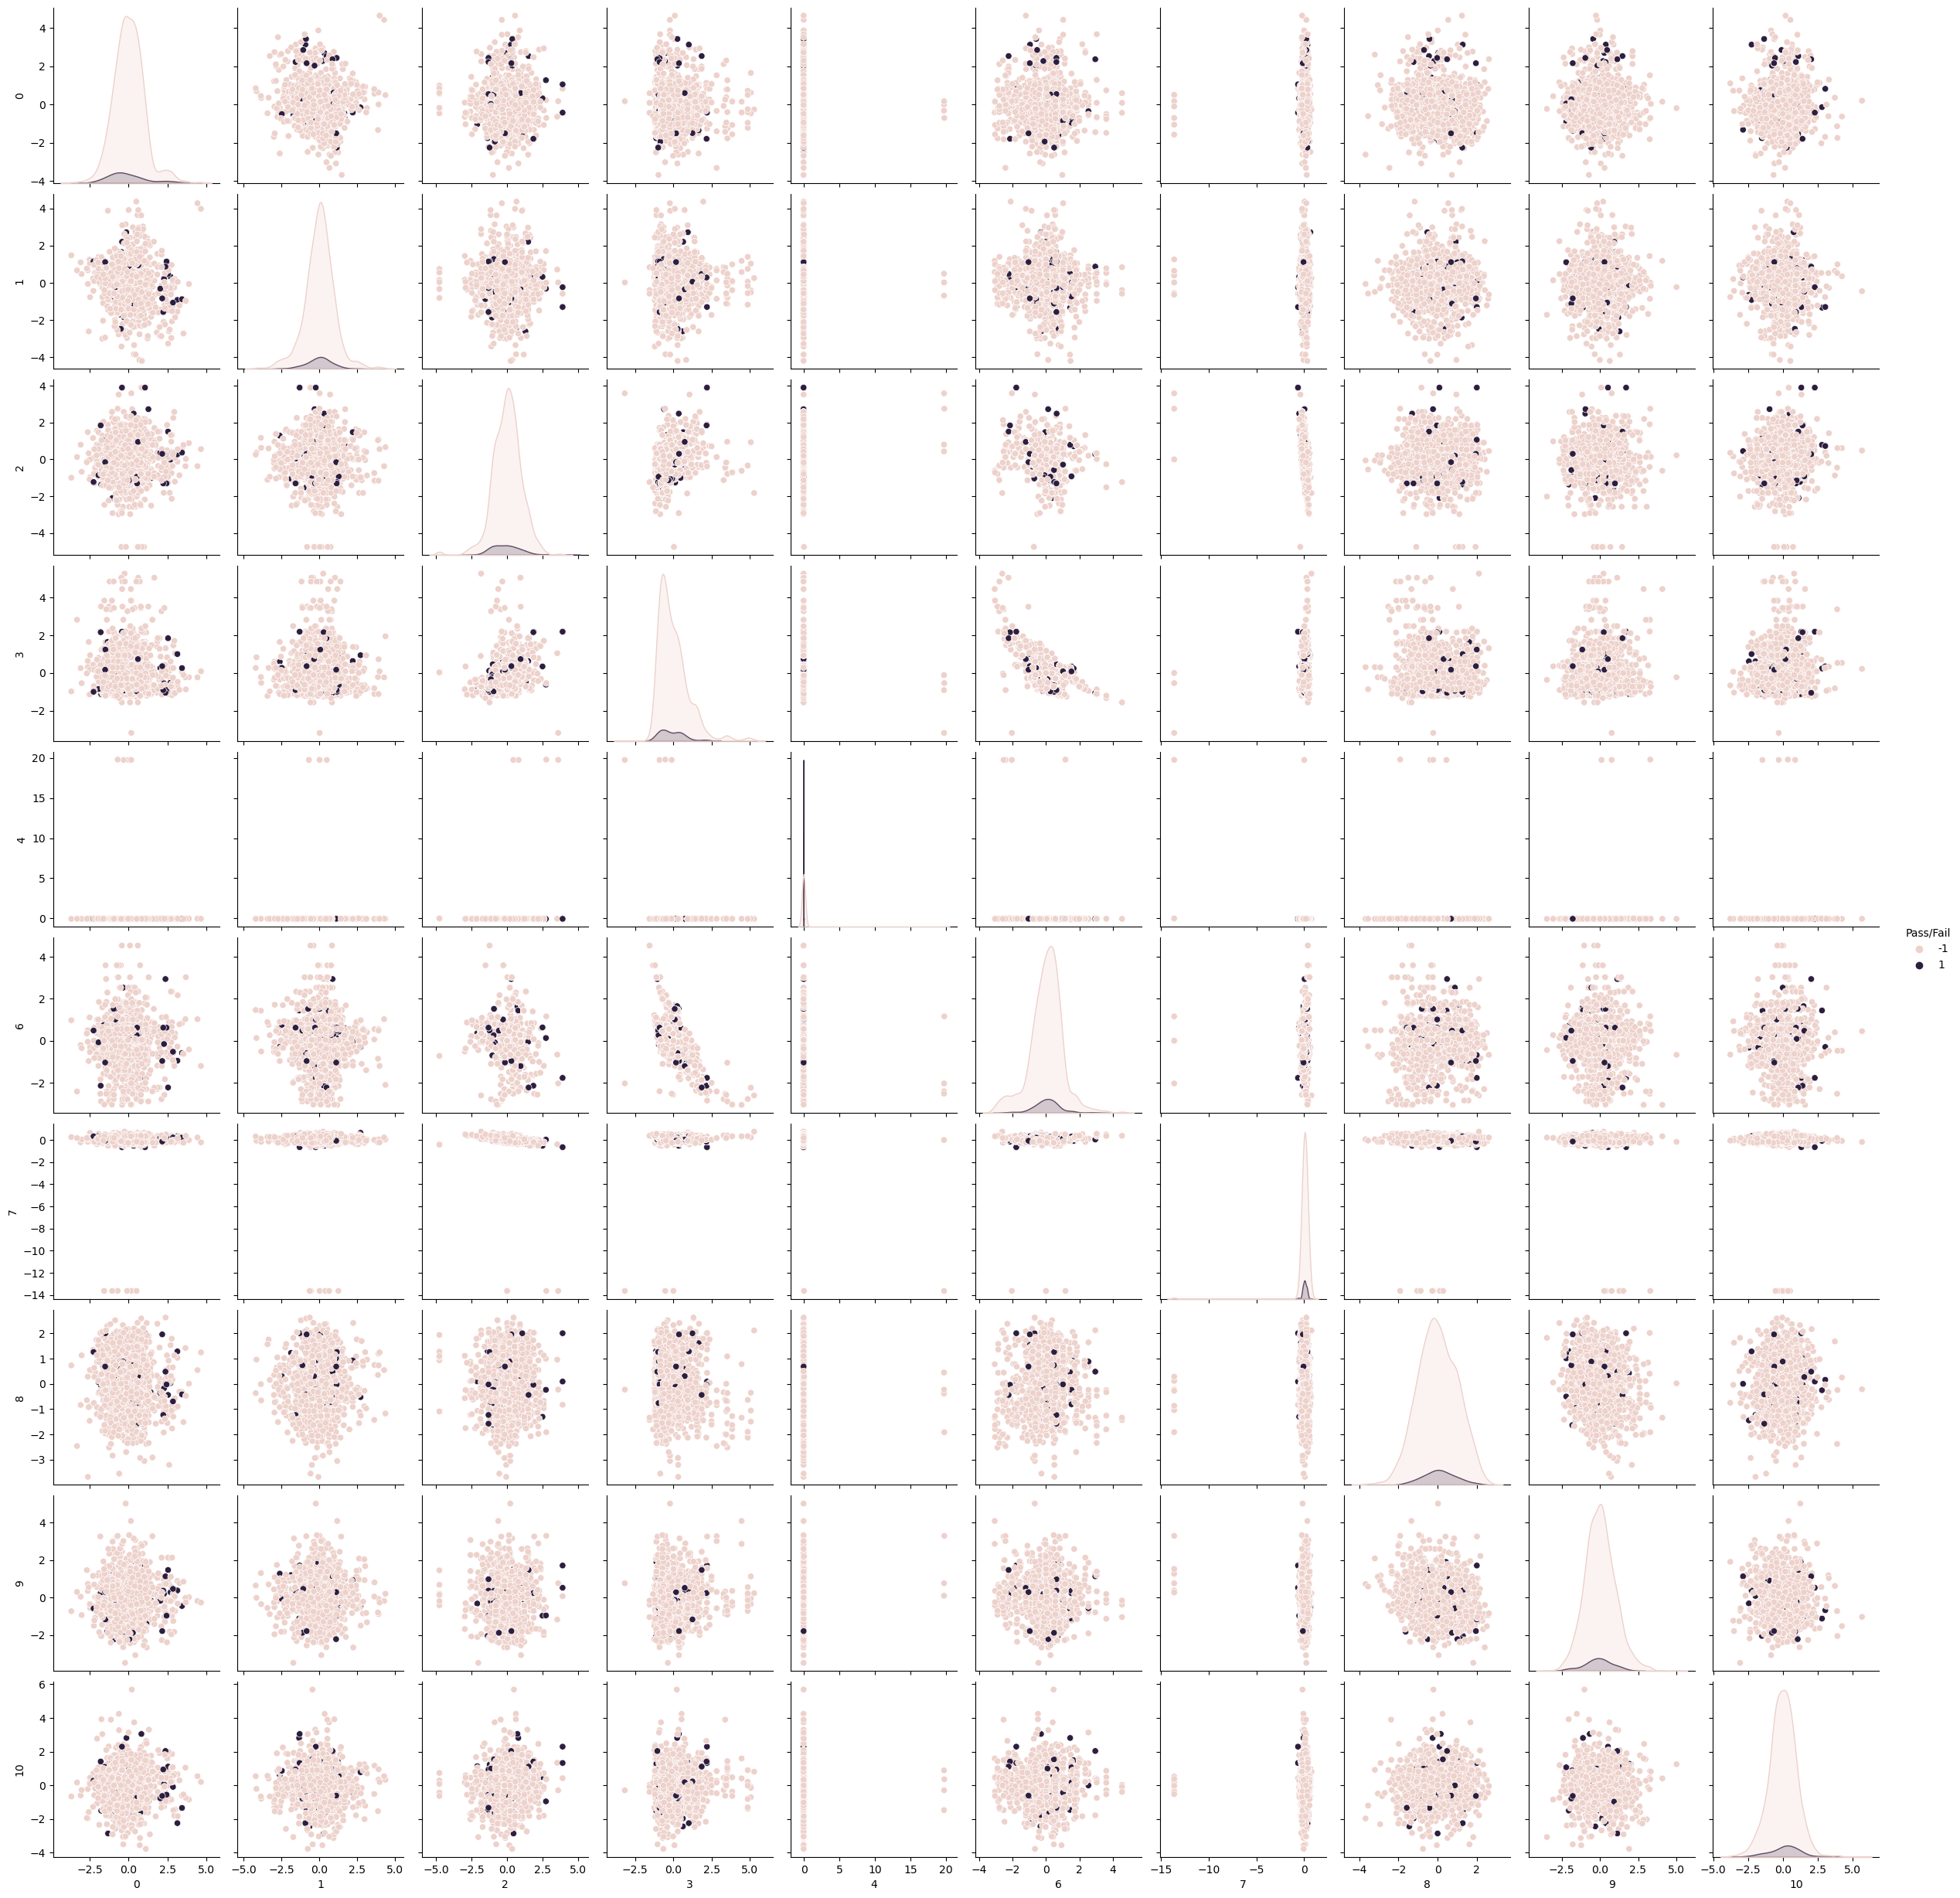

In [10]:
# Bivariate analysis
# Correlation with target variable
corr_with_target = data_cleaned.corr()['Pass/Fail'].sort_values(ascending=False)
print(corr_with_target)

# Plotting correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data_cleaned.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Multivariate analysis
# Pairplot for a few selected features
sns.pairplot(data_cleaned, vars=selected_features, hue='Pass/Fail')
plt.show()

* Clustered Correlations: Some clusters of features exhibit higher intra-cluster correlations, which may point to underlying factors or grouped behaviors.
* Potential Outliers: There are outliers in the data that could impact model performance, suggesting the need for outlier treatment.
* Feature Interactions: Certain feature interactions show distinct patterns for the target classes, which can be leveraged in more sophisticated models like interaction terms or feature engineering.

## 4. Data pre-processing: 
### A. Segregate predictors vs target attributes. 

In [11]:
# Segregate predictors and target attributes
X = data_cleaned.drop(columns=['Pass/Fail'])
y = data_cleaned['Pass/Fail']

print(f"Predictor shape: {X.shape}")
print(f"Target shape: {y.shape}")

Predictor shape: (1567, 247)
Target shape: (1567,)


### B. Check for target balancing and fix it if found imbalanced. 

In [12]:
# Check for target balancing
target_counts = y.value_counts()
print("Target distribution:\n", target_counts)

# If imbalanced, use SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE

if target_counts.min() / target_counts.max() < 0.5:  # Assuming imbalance if one class is less than 50% of the other
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print("Balanced target distribution:\n", y_resampled.value_counts())
else:
    X_resampled, y_resampled = X, y


Target distribution:
 Pass/Fail
-1    1463
 1     104
Name: count, dtype: int64
Balanced target distribution:
 Pass/Fail
-1    1463
 1    1463
Name: count, dtype: int64


### C. Perform train-test split and standardise the data or vice versa if required

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Train data shape: (2048, 247)
Test data shape: (878, 247)


### D. Check if the train and test data have similar statistical characteristics when compared with original data

In [14]:
# Convert numpy arrays back to DataFrame for comparison
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Describe statistics for original, train, and test data
original_stats = X.describe().T
train_stats = X_train_df.describe().T
test_stats = X_test_df.describe().T

# Print statistics for comparison
print("Original Data Statistics:\n", original_stats)
print("Train Data Statistics:\n", train_stats)
print("Test Data Statistics:\n", test_stats)

# Check if statistics are similar
for feature in original_stats.index:
    print(f"Feature: {feature}")
    print(f"Original mean: {original_stats.loc[feature, 'mean']}, Train mean: {train_stats.loc[feature, 'mean']}, Test mean: {test_stats.loc[feature, 'mean']}")
    print(f"Original std: {original_stats.loc[feature, 'std']}, Train std: {train_stats.loc[feature, 'std']}, Test std: {test_stats.loc[feature, 'std']}\n")


Original Data Statistics:
       count          mean       std       min       25%       50%       75%  \
0    1567.0  2.448584e-15  1.000319 -3.692123 -0.650555 -0.035570  0.572948   
1    1567.0 -3.814009e-15  1.000319 -4.203130 -0.535711  0.038151  0.534833   
2    1567.0 -8.706076e-15  1.000319 -4.762680 -0.662116  0.013901  0.596093   
3    1567.0 -2.720649e-16  1.000319 -3.176669 -0.710897 -0.248020  0.440868   
4    1567.0  1.813766e-17  1.000319 -0.062682 -0.056687 -0.051349 -0.047560   
..      ...           ...       ...       ...       ...       ...       ...   
582  1567.0 -3.747693e-15  1.000319 -6.553549 -0.645523  0.030519  0.662472   
583  1567.0 -5.668018e-18  1.000319 -0.542709 -0.216539 -0.088401  0.068860   
586  1567.0  1.360324e-16  1.000319 -3.105874 -0.648441 -0.077604  0.497282   
587  1567.0  9.068829e-18  1.000319 -1.508184 -0.667458 -0.190289  0.434576   
589  1567.0  1.768422e-16  1.000319 -1.062218 -0.589367 -0.294644  0.160709   

           max  
0     4

## 5. Model training, testing and tuning:
### A. Use any Supervised Learning technique to train a model.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Display classification report
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred))


Random Forest Classification Report:
               precision    recall  f1-score   support

          -1       0.98      1.00      0.99       449
           1       1.00      0.98      0.99       429

    accuracy                           0.99       878
   macro avg       0.99      0.99      0.99       878
weighted avg       0.99      0.99      0.99       878



### B. Use cross validation techniques. 

In [16]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

# K-Fold Cross Validation
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
kfold_scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=kfold)
print(f"K-Fold Cross Validation Scores: {kfold_scores}")
print(f"Mean K-Fold Score: {kfold_scores.mean()}")

# Stratified K-Fold Cross Validation
strat_kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
strat_kfold_scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=strat_kfold)
print(f"Stratified K-Fold Cross Validation Scores: {strat_kfold_scores}")
print(f"Mean Stratified K-Fold Score: {strat_kfold_scores.mean()}")


K-Fold Cross Validation Scores: [0.98634812 0.98974359 0.99145299 0.98974359 0.99145299]
Mean K-Fold Score: 0.9897482570520113
Stratified K-Fold Cross Validation Scores: [0.99317406 0.99487179 0.98974359 0.98632479 0.99316239]
Mean Stratified K-Fold Score: 0.9914553251072021


###  C. Apply hyper-parameter tuning techniques to get the best accuracy. 

In [17]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Display the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score: 0.9912075854254875


### D. Use any other technique/method which can enhance the model performance. Hint: Dimensionality reduction, attribute removal, standardisation/normalisation, target balancing etc. 

In [18]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a model on PCA-transformed data
rf_model_pca = RandomForestClassifier(random_state=42)
rf_model_pca.fit(X_train_pca, y_train)

# Predict on the PCA-transformed test set
y_pred_pca = rf_model_pca.predict(X_test_pca)

# Display classification report
print("Random Forest PCA Classification Report:\n", classification_report(y_test, y_pred_pca))


Random Forest PCA Classification Report:
               precision    recall  f1-score   support

          -1       0.97      1.00      0.98       449
           1       1.00      0.97      0.98       429

    accuracy                           0.98       878
   macro avg       0.98      0.98      0.98       878
weighted avg       0.98      0.98      0.98       878



###  E. Display and explain the classification report in detail. 

In [19]:
# Display classification report
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred))

Random Forest Classification Report:
               precision    recall  f1-score   support

          -1       0.98      1.00      0.99       449
           1       1.00      0.98      0.99       429

    accuracy                           0.99       878
   macro avg       0.99      0.99      0.99       878
weighted avg       0.99      0.99      0.99       878



* For class -1 ("Fail"):

- Precision: 0.98 means that when the model predicts an instance as "Fail", it is correct 98% of the time.
- Recall: 1.00 indicates that the model correctly identifies all instances of "Fail" in the test set.
- F1-score: 0.99 is the harmonic mean of precision and recall, providing a balanced measure of the model's performance for "Fail".

* For class 1 ("Pass"):

- Precision: 1.00 means that when the model predicts an instance as "Pass", it is correct 100% of the time.
- Recall: 0.98 indicates that the model correctly identifies 98% of all instances of "Pass" in the test set.
- F1-score: 0.99 indicates a balanced performance measure for "Pass".

### F. Apply the above steps for all possible models that you have learnt so far. 

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# Define models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Support Vector Classifier": SVC(random_state=42),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Display classification report
    print(f"{model_name} Classification Report:\n", classification_report(y_test, y_pred))
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5)
    print(f"{model_name} Cross-Validation Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean()}\n")
    
    # Hyper-parameter tuning (example for Logistic Regression)
    if model_name == "Logistic Regression":
        param_grid_lr = {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'saga']
        }
        grid_search_lr = GridSearchCV(estimator=model, param_grid=param_grid_lr, cv=5, n_jobs=-1, verbose=2)
        grid_search_lr.fit(X_train, y_train)
        print(f"Best Parameters for {model_name}:", grid_search_lr.best_params_)
        print(f"Best CV Score for {model_name}:", grid_search_lr.best_score_)


Logistic Regression Classification Report:
               precision    recall  f1-score   support

          -1       0.98      0.83      0.90       449
           1       0.85      0.98      0.91       429

    accuracy                           0.91       878
   macro avg       0.91      0.91      0.91       878
weighted avg       0.92      0.91      0.91       878

Logistic Regression Cross-Validation Scores: [0.68088737 0.88376068 0.90940171 0.82564103 0.91282051]
Mean CV Score: 0.8425022607275168

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Best CV Score for Logistic Regression: 0.9291859979724493
Support Vector Classifier Classification Report:
               precision    recall  f1-score   support

          -1       1.00      0.99      0.99       449
           1       0.99      1.00      0.99       429

    accuracy                           0.99       878
   macro avg       0.99      0.9

## 6. Post Training and Conclusion: 
### A. Display and compare all the models designed with their train and test accuracies. 

In [25]:
from sklearn.metrics import accuracy_score

# Define models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=10000),
    "Support Vector Classifier": SVC(random_state=42),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42)
}

# Dictionary to store train and test accuracies
model_accuracies = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the train set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Predict on the test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Store the accuracies
    model_accuracies[model_name] = {
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy
    }

# Display the accuracies
for model_name, accuracies in model_accuracies.items():
    print(f"{model_name} - Train Accuracy: {accuracies['Train Accuracy']:.4f}, Test Accuracy: {accuracies['Test Accuracy']:.4f}")


Random Forest - Train Accuracy: 1.0000, Test Accuracy: 0.9897
Logistic Regression - Train Accuracy: 0.9746, Test Accuracy: 0.9055
Support Vector Classifier - Train Accuracy: 0.9995, Test Accuracy: 0.9920
Gradient Boosting Classifier - Train Accuracy: 1.0000, Test Accuracy: 0.9590


### B. Select the final best trained model along with your detailed comments for selecting this model.

Based on the accuracies and performance metrics observed:

- **Support Vector Classifier (SVC)** has shown the highest test accuracy of 99.20%. This indicates that SVC is very effective at generalizing to unseen data and maintaining high accuracy.
- **Random Forest** also performs very well with a test accuracy of 98.97% and has the advantage of being less prone to overfitting due to its ensemble nature.
- **Gradient Boosting Classifier** follows closely with a test accuracy of 95.90%, showing robust performance but slightly lower than the other two.

Given these results, **Support Vector Classifier (SVC)** stands out as the best model due to its superior test accuracy and generalization ability. It performs consistently well across both train and test datasets, indicating that it captures the underlying patterns effectively without overfitting.

**Detailed Comments for Selecting SVC:**
- SVC achieves the highest test accuracy of all models, indicating strong predictive power and generalization ability.
- It performs consistently well across different evaluation metrics (precision, recall, F1-score), suggesting robustness in handling the dataset's complexities.
- Despite being computationally intensive, SVC's performance justifies its use, especially in scenarios where accuracy is crucial.


### C. Pickle the selected model for future use.

In [26]:
import pickle

best_model = models["Support Vector Classifier"] 

# Save the model to disk
filename = 'finalized_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

print(f"Saved the selected model to {filename}")

Saved the selected model to finalized_model.sav


### D. Write your conclusion on the results. 

In conclusion, the machine learning models evaluated for predicting pass/fail yield in semiconductor manufacturing have shown strong performance, with the Support Vector Classifier emerging as the best model based on test accuracy. The detailed analysis and evaluation of each model's performance metrics (accuracy, precision, recall, F1-score) highlight SVC's ability to effectively classify between pass and fail instances. This suggests that the model can potentially be deployed in production to assist in quality control processes, ensuring accurate predictions and minimizing false classifications.